In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from datetime import datetime
import matplotlib.pyplot as plt

In [9]:
V = yf.Ticker('V')
aapl = yf.Ticker('AAPL')
baba = yf.Ticker('BABA')

In [10]:
START = datetime(2010, 1, 1)
END = datetime(2020, 8, 21)

In [11]:
Vhist = V.history(start=START, end=END).dropna()
Ahist = aapl.history(start=START, end=END).dropna()
Bhist = baba.history(start=START, end=END).dropna()


In [12]:
dta = pd.concat([Vhist.Close, Ahist.Close, Bhist.Close], axis=1)
dta.columns = ['V', 'A', 'B']

In [13]:
dta.dropna(inplace=True)

In [2]:
def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    # NHLI not traded
    dta.drop(['Date', 'NHLI'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    for tick in dta.columns:
        dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

    return dta[dta.index >= dta['SPY'].first_valid_index()]

In [102]:
dta = pd.read_csv('broader_stock.csv')
sp = pd.read_csv('sp500_stock.csv')

dta = data_preprocess(dta)
sp = data_preprocess(sp)

In [103]:
smooth_sp = sp.rolling(20).mean().iloc[19:]
smooth_dta = dta.rolling(20).mean().iloc[19:]

# Price level model

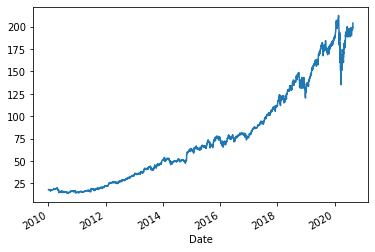

In [11]:
hist.Close.plot()

In [50]:
smooth = hist.Close.rolling(5).mean()

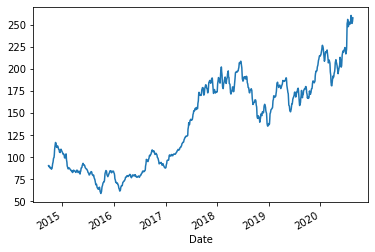

In [51]:
smooth.plot()

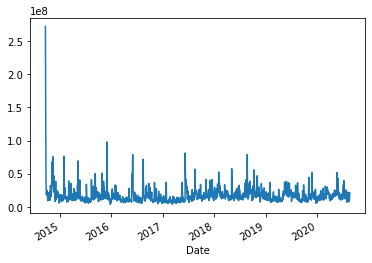

In [52]:
hist.Volume.plot()

In [4]:
from scipy.stats import kurtosis, iqr
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import arch

# ML imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [54]:
smooth.dropna(inplace=True)

In [55]:
smooth

Date
2014-09-25     90.088
2014-09-26     89.402
2014-09-29     89.174
2014-09-30     89.510
2014-10-01     88.616
               ...   
2020-08-14    251.886
2020-08-17    253.652
2020-08-18    255.808
2020-08-19    256.888
2020-08-20    257.738
Name: Close, Length: 1487, dtype: float64

In [56]:
smooth.iloc[0:10]

Date
2014-09-25    90.088
2014-09-26    89.402
2014-09-29    89.174
2014-09-30    89.510
2014-10-01    88.616
2014-10-02    88.244
2014-10-03    87.772
2014-10-06    87.684
2014-10-07    87.448
2014-10-08    87.888
Name: Close, dtype: float64

In [99]:
X = []
Y = []

for i in range(len(hist)-30):
    x = hist.Close.iloc[i:i+30].values
    y = hist.Close.iloc[i+30]
    X.append(x)
    Y.append(y)

In [100]:
X = np.array(X)
Y = np.array(Y).reshape(-1,1)

In [101]:
X.shape, Y.shape

((2647, 30), (2647, 1))

In [125]:
cutoff = int(X.shape[0] * 0.8)

mm_scaler_x = MinMaxScaler()
tempx = X[:cutoff,:]

mm_scaler_y = MinMaxScaler()
tempy = Y[:cutoff]

mm_scaler_x = mm_scaler_x.fit(tempx)
mm_scaler_y = mm_scaler_y.fit(tempy)

scale_X = mm_scaler_x.transform(X)
scale_Y = mm_scaler_y.transform(Y)

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(scale_X, scale_Y, test_size=0.2)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [5]:
def coeff_deter(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred) * 1e6)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)) * 1e6)
    return 1 - SS_res / (SS_tot + K.epsilon())

In [128]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)

In [129]:
model.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])

Train on 2117 samples, validate on 530 samples
Epoch 1/50
2117/2117 [==============================] - 1s 620us/step - loss: 0.1439 - coeff_deter: 0.6624 - val_loss: 0.0303 - val_coeff_deter: 0.9880
Epoch 2/50
2117/2117 [==============================] - 0s 207us/step - loss: 0.0706 - coeff_deter: 0.9284 - val_loss: 0.0347 - val_coeff_deter: 0.9865
Epoch 3/50
2117/2117 [==============================] - 0s 199us/step - loss: 0.0650 - coeff_deter: 0.9369 - val_loss: 0.0237 - val_coeff_deter: 0.9911
Epoch 4/50
2117/2117 [==============================] - 0s 197us/step - loss: 0.0642 - coeff_deter: 0.9384 - val_loss: 0.0268 - val_coeff_deter: 0.9872
Epoch 5/50
2117/2117 [==============================] - 0s 193us/step - loss: 0.0608 - coeff_deter: 0.9463 - val_loss: 0.0340 - val_coeff_deter: 0.9864
Epoch 6/50
2117/2117 [==============================] - 0s 198us/step - loss: 0.0563 - coeff_deter: 0.9571 - val_loss: 0.0309 - val_coeff_deter: 0.9828
Epoch 7/50
2117/2117 [===================

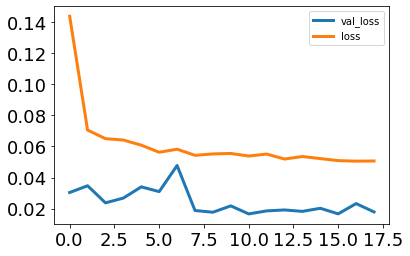

In [130]:
plot_kwargs = {'fontsize': 18, 'linewidth': 3, 'figsize': (6,4)}
pd.DataFrame(model.history.history)[['val_loss', 'loss']].plot(**plot_kwargs)

In [137]:
train = X[:cutoff,:]
scale = mm_scaler_x.transform(train)

scale = scale.reshape(scale.shape[0], 1, scale.shape[1])
y_fit = model.predict(scale)
y_fit = mm_scaler_y.inverse_transform()

y_fit = mm_scaler_y.inverse_transform(y_fit)

In [131]:
y_fit = model.predict(X_train)
y_fit = y_fit.flatten()

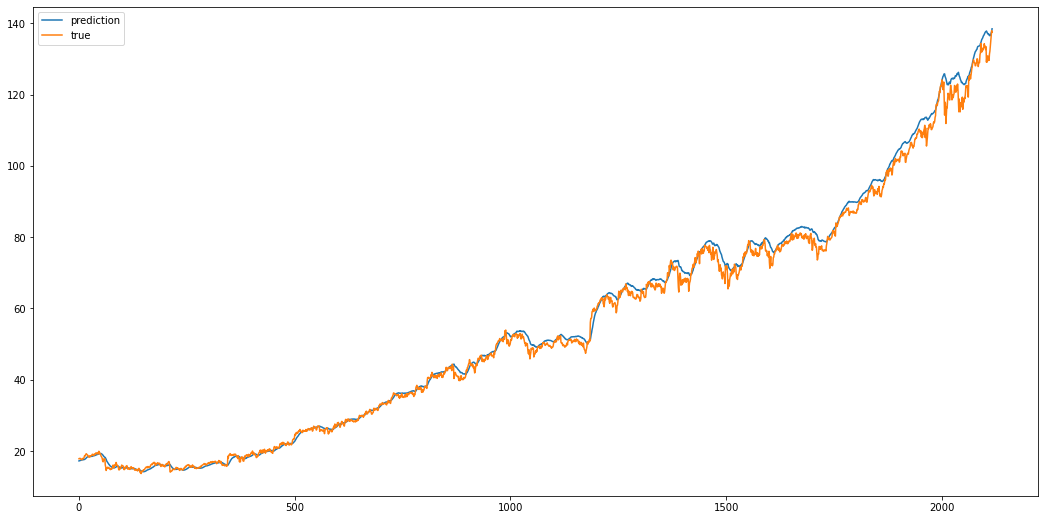

In [149]:
plt.figure(figsize=(18,9))
plt.plot(y_fit)
plt.plot(y_true)
plt.legend(['prediction', 'true'])

In [133]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

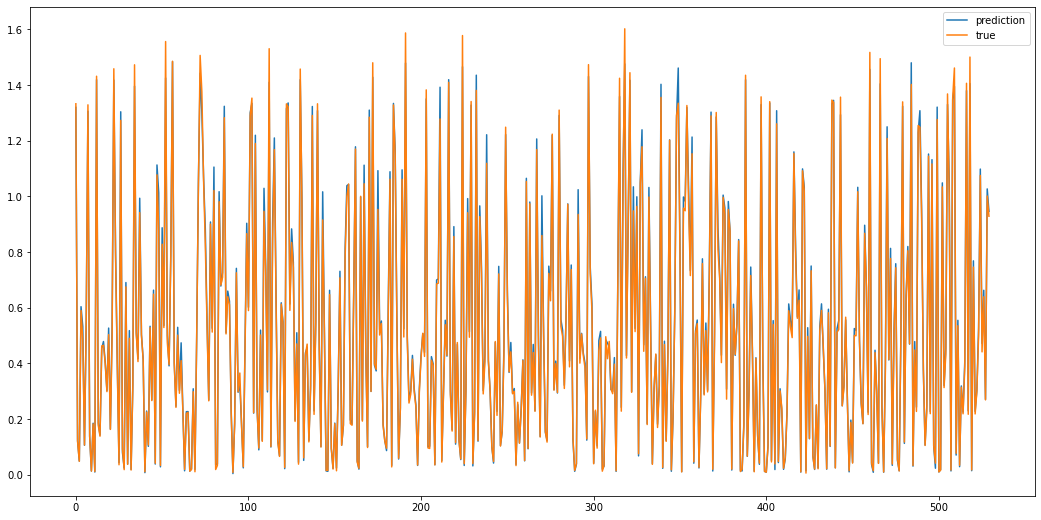

In [134]:
plt.figure(figsize=(18,9))
pd.Series(y_pred).plot()
pd.Series(Y_test.flatten()).plot()
plt.legend(['prediction', 'true'])

In [135]:
r2_in = r2_score(Y_train, y_fit)
r2_os = r2_score(Y_test, y_pred)

print("The in-sampel R-squared is {}, and the out-of-sampel R-square is {}.".format(r2_in, r2_os))

The in-sampel R-squared is 0.9960107989834979, and the out-of-sampel R-square is 0.9954248573980349.


# That seems crazy but whatabout its predictability for 5-day return

In [109]:
X = []
Y = []

for i in range(len(smooth)-35):
    x = hist.Close.iloc[i:i+30].values
    y1 = hist.Close.iloc[i+30]
    y2 = hist.Close.iloc[i+34]
    y = (y2 - y1) / y1
    X.append(x)
    Y.append(y)

In [110]:
X = np.array(X)
Y = np.array(Y).reshape(-1,1)

X.shape, Y.shape

((1452, 30), (1452, 1))

In [89]:
cutoff = int(X.shape[0] * 0.8)

mm_scaler_x = MinMaxScaler()
tempx = X[:cutoff,:]

mm_scaler_y = MinMaxScaler()
tempy = Y[:cutoff]

mm_scaler_x = mm_scaler_x.fit(tempx)
mm_scaler_y = mm_scaler_y.fit(tempy)

scale_X = mm_scaler_x.transform(X)
scale_Y = mm_scaler_y.transform(Y)

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(scale_X, scale_Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [91]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)

In [92]:
model.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])

Train on 1161 samples, validate on 291 samples
Epoch 1/50
1161/1161 [==============================] - 1s 737us/step - loss: 0.2524 - coeff_deter: -4.9295 - val_loss: 0.1774 - val_coeff_deter: -1.7254
Epoch 2/50
1161/1161 [==============================] - 0s 215us/step - loss: 0.1560 - coeff_deter: -1.2914 - val_loss: 0.1203 - val_coeff_deter: -0.3726
Epoch 3/50
1161/1161 [==============================] - 0s 207us/step - loss: 0.1223 - coeff_deter: -0.4477 - val_loss: 0.1062 - val_coeff_deter: -0.1045
Epoch 4/50
1161/1161 [==============================] - 0s 221us/step - loss: 0.1202 - coeff_deter: -0.4251 - val_loss: 0.1067 - val_coeff_deter: -0.0978
Epoch 5/50
1161/1161 [==============================] - 0s 201us/step - loss: 0.1190 - coeff_deter: -0.3920 - val_loss: 0.1039 - val_coeff_deter: -0.0641
Epoch 6/50
1161/1161 [==============================] - 0s 200us/step - loss: 0.1159 - coeff_deter: -0.2704 - val_loss: 0.1039 - val_coeff_deter: -0.0573
Epoch 7/50
1161/1161 [=======

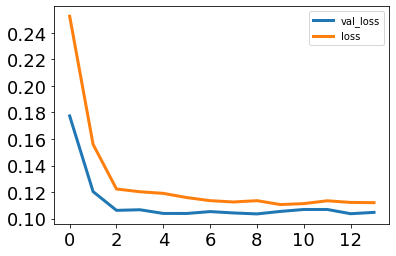

In [93]:
plot_kwargs = {'fontsize': 18, 'linewidth': 3, 'figsize': (6,4)}
pd.DataFrame(model.history.history)[['val_loss', 'loss']].plot(**plot_kwargs)

In [94]:
y_fit = model.predict(X_train)
y_fit = y_fit.flatten()

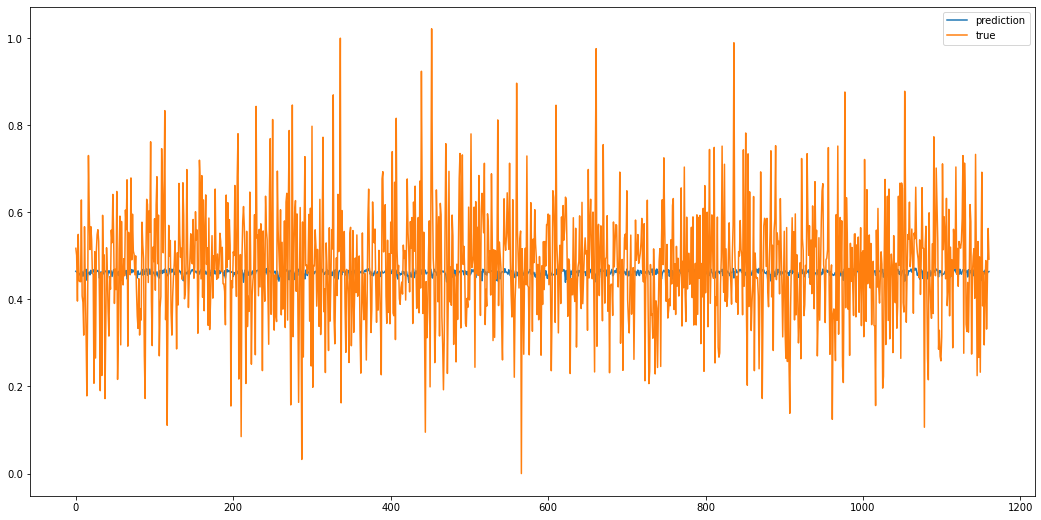

In [95]:
plt.figure(figsize=(18,9))
pd.Series(y_fit).plot()
pd.Series(Y_train.flatten()).plot()
plt.legend(['prediction', 'true'])

In [96]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

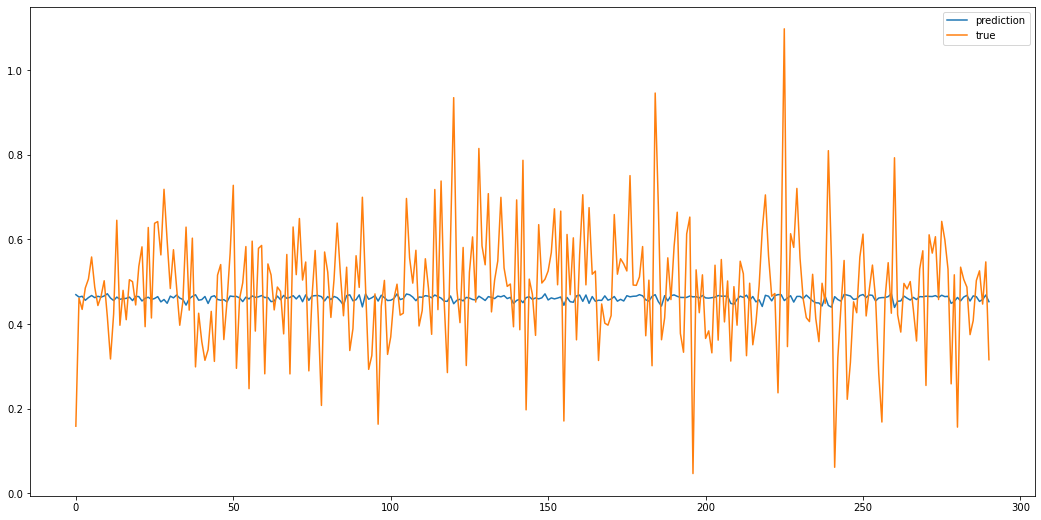

In [97]:
plt.figure(figsize=(18,9))
pd.Series(y_pred).plot()
pd.Series(Y_test.flatten()).plot()
plt.legend(['prediction', 'true'])

In [98]:
r2_in = r2_score(Y_train, y_fit)
r2_os = r2_score(Y_test, y_pred)

print("The in-sampel R-squared is {}, and the out-of-sampel R-square is {}.".format(r2_in, r2_os))

The in-sampel R-squared is -0.012709920916897932, and the out-of-sampel R-square is -0.03785333017885839.


# Then what about using returns to predict returns

In [10]:
X = []
Y = []

for i in range(len(smooth)-36):
    x1 = hist.Close.iloc[i:i+31].values
    x = np.diff(x1) / x1[1:]
    y1 = hist.Close.iloc[i+31]
    y2 = hist.Close.iloc[i+35]
    y = (y2 - y1) / y1
    X.append(x)
    Y.append(y)

NameError: name 'smooth' is not defined

In [11]:
X = np.array(X)
Y = np.array(Y).reshape(-1,1)

X.shape, Y.shape

((0,), (0, 1))

In [113]:
cutoff = int(X.shape[0] * 0.8)

mm_scaler_x = MinMaxScaler()
tempx = X[:cutoff,:]

mm_scaler_y = MinMaxScaler()
tempy = Y[:cutoff]

mm_scaler_x = mm_scaler_x.fit(tempx)
mm_scaler_y = mm_scaler_y.fit(tempy)

scale_X = mm_scaler_x.transform(X)
scale_Y = mm_scaler_y.transform(Y)

In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(scale_X, scale_Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [115]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)

In [116]:
model.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])

Train on 1160 samples, validate on 291 samples
Epoch 1/50
1160/1160 [==============================] - 1s 805us/step - loss: 0.2147 - coeff_deter: -3.4278 - val_loss: 0.1102 - val_coeff_deter: -0.1144
Epoch 2/50
1160/1160 [==============================] - 0s 201us/step - loss: 0.1241 - coeff_deter: -0.4650 - val_loss: 0.1053 - val_coeff_deter: -0.0413
Epoch 3/50
1160/1160 [==============================] - 0s 201us/step - loss: 0.1218 - coeff_deter: -0.3935 - val_loss: 0.1052 - val_coeff_deter: -0.0338
Epoch 4/50
1160/1160 [==============================] - 0s 203us/step - loss: 0.1192 - coeff_deter: -0.3863 - val_loss: 0.1052 - val_coeff_deter: -0.0319
Epoch 5/50
1160/1160 [==============================] - 0s 210us/step - loss: 0.1183 - coeff_deter: -0.3370 - val_loss: 0.1050 - val_coeff_deter: -0.0323
Epoch 6/50
1160/1160 [==============================] - 0s 204us/step - loss: 0.1180 - coeff_deter: -0.3321 - val_loss: 0.1050 - val_coeff_deter: -0.0336
Epoch 7/50
1160/1160 [=======

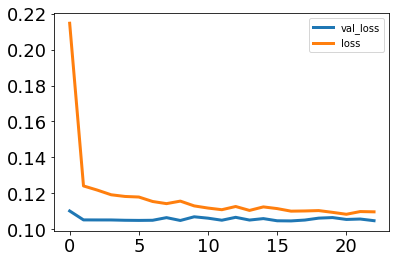

In [117]:
plot_kwargs = {'fontsize': 18, 'linewidth': 3, 'figsize': (6,4)}
pd.DataFrame(model.history.history)[['val_loss', 'loss']].plot(**plot_kwargs)

In [118]:
y_fit = model.predict(X_train)
y_fit = y_fit.flatten()

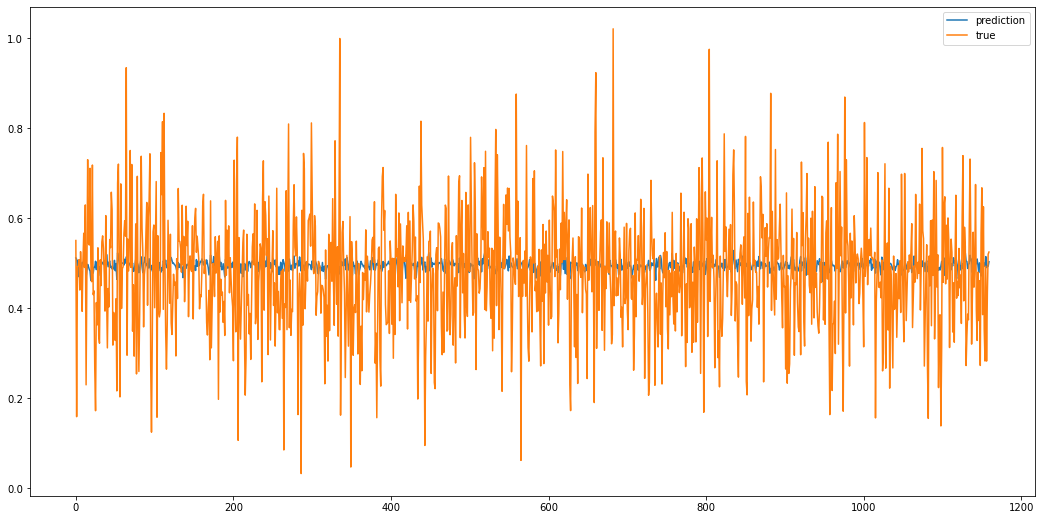

In [119]:
plt.figure(figsize=(18,9))
pd.Series(y_fit).plot()
pd.Series(Y_train.flatten()).plot()
plt.legend(['prediction', 'true'])

In [120]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

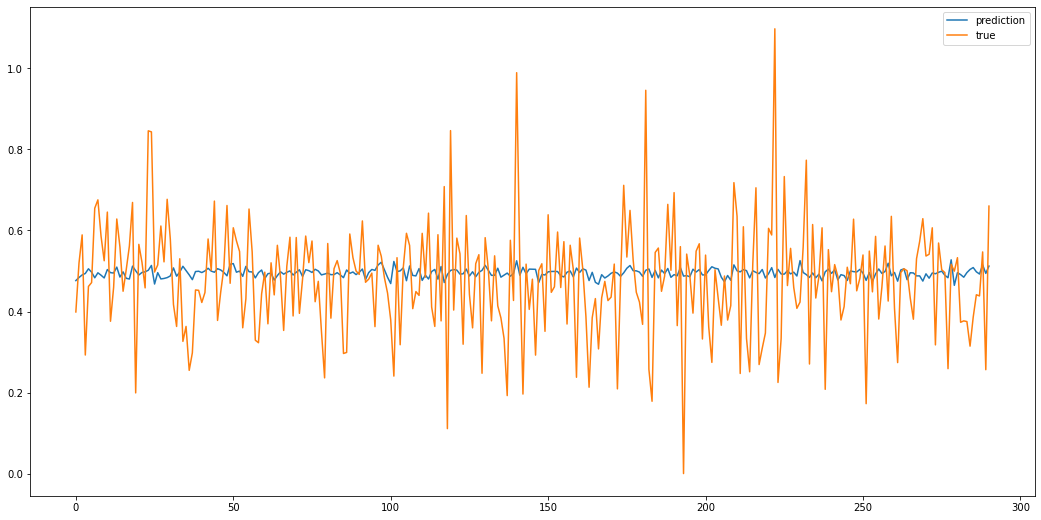

In [121]:
plt.figure(figsize=(18,9))
pd.Series(y_pred).plot()
pd.Series(Y_test.flatten()).plot()
plt.legend(['prediction', 'true'])

In [122]:
r2_in = r2_score(Y_train, y_fit)
r2_os = r2_score(Y_test, y_pred)

print("The in-sampel R-squared is {}, and the out-of-sampel R-square is {}.".format(r2_in, r2_os))

The in-sampel R-squared is 0.0010250836891239068, and the out-of-sampel R-square is -0.007886473729109778.


# These are epic failures. But can't we predict price level one day and five day ahead and then calculate returns afterward?

In [28]:
dta['AME'].iloc[30:40]

Date
1993-03-15    0.71
1993-03-16    0.72
1993-03-17    0.73
1993-03-18    0.76
1993-03-19    0.75
1993-03-22    0.75
1993-03-23    0.78
1993-03-24    0.80
1993-03-25    0.81
1993-03-26    0.79
Name: AME, dtype: float64

In [27]:
sp[['TROW', 'ECL', 'PH']].iloc[0:30].values.T.flatten()

array([1.45, 1.46, 1.43, 1.41, 1.41, 1.43, 1.43, 1.43, 1.43, 1.42, 1.41,
       1.37, 1.35, 1.31, 1.3 , 1.28, 1.29, 1.31, 1.31, 1.34, 1.33, 1.35,
       1.39, 1.41, 1.41, 1.41, 1.41, 1.41, 1.4 , 1.38, 2.12, 2.12, 2.17,
       2.19, 2.27, 2.25, 2.24, 2.23, 2.25, 2.25, 2.22, 2.2 , 2.2 , 2.19,
       2.22, 2.27, 2.26, 2.17, 2.16, 2.14, 2.12, 2.12, 2.12, 2.12, 2.1 ,
       2.16, 2.16, 2.22, 2.22, 2.22, 4.29, 4.32, 4.37, 4.42, 4.37, 4.47,
       4.4 , 4.37, 4.35, 4.48, 4.44, 4.28, 4.26, 4.28, 4.26, 4.26, 4.24,
       4.33, 4.36, 4.36, 4.31, 4.36, 4.36, 4.28, 4.28, 4.39, 4.43, 4.38,
       4.41, 4.31])

In [146]:
dta['AME'].iloc[[4130,4160,4190]]

Date
2009-06-23    13.36
2009-08-05    12.79
2009-09-17    14.59
Name: AME, dtype: float64

In [47]:
X = []
Y = []

for i in range(len(dta)-30):
    x = sp[['PH', 'UNP', 'ROP', 'LIN']].iloc[i:i+30].values.T.flatten()
    y = dta['AME'].iloc[[i+30]].values
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)


(6907, 120) (6907, 1)


In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

mm_scaler_x = StandardScaler()
mm_scaler_y = StandardScaler()

mm_scaler_x = mm_scaler_x.fit(X_train)
mm_scaler_y = mm_scaler_y.fit(Y_train)

X_train = mm_scaler_x.transform(X_train)
Y_train = mm_scaler_y.transform(Y_train)

X_test = mm_scaler_x.transform(X_test)
Y_test = mm_scaler_y.transform(Y_test)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


initializer = initializers.glorot_normal()
model_1 = Sequential()
model_1.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer, return_sequences=True))
model_1.add(Dropout(0.4))
model_1.add(LSTM(25, kernel_initializer=initializer))
model_1.add(Dropout(0.4))
model_1.add(Dense(1, kernel_initializer=initializer))
model_1.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)


model_1.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])

Train on 4144 samples, validate on 2763 samples
Epoch 1/50
4144/4144 [==============================] - 2s 603us/step - loss: 0.2261 - coeff_deter: 0.8617 - val_loss: 0.0848 - val_coeff_deter: 0.9834
Epoch 2/50
4144/4144 [==============================] - 1s 275us/step - loss: 0.1582 - coeff_deter: 0.9390 - val_loss: 0.1242 - val_coeff_deter: 0.9624
Epoch 3/50
4144/4144 [==============================] - 1s 254us/step - loss: 0.1525 - coeff_deter: 0.9426 - val_loss: 0.0600 - val_coeff_deter: 0.9875
Epoch 4/50
4144/4144 [==============================] - 1s 253us/step - loss: 0.1415 - coeff_deter: 0.9512 - val_loss: 0.0600 - val_coeff_deter: 0.9898
Epoch 5/50
4144/4144 [==============================] - 1s 255us/step - loss: 0.1451 - coeff_deter: 0.9475 - val_loss: 0.0609 - val_coeff_deter: 0.9861
Epoch 6/50
4144/4144 [==============================] - 1s 251us/step - loss: 0.1368 - coeff_deter: 0.9507 - val_loss: 0.0763 - val_coeff_deter: 0.9858
Epoch 7/50
4144/4144 [==================

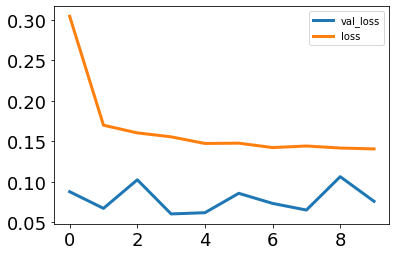

In [62]:
plot_kwargs = {'fontsize': 18, 'linewidth': 3, 'figsize': (6,4)}
pd.DataFrame(model.history.history)[['val_loss', 'loss']].plot(**plot_kwargs)

In [63]:
train = X[:int(X.shape[0] * 0.8),:]
scale = mm_scaler_x.transform(train)

scale = scale.reshape(scale.shape[0], 1, scale.shape[1])
y_fit_30 = model.predict(scale)

y_fit_30 = mm_scaler_y.inverse_transform(y_fit_30)

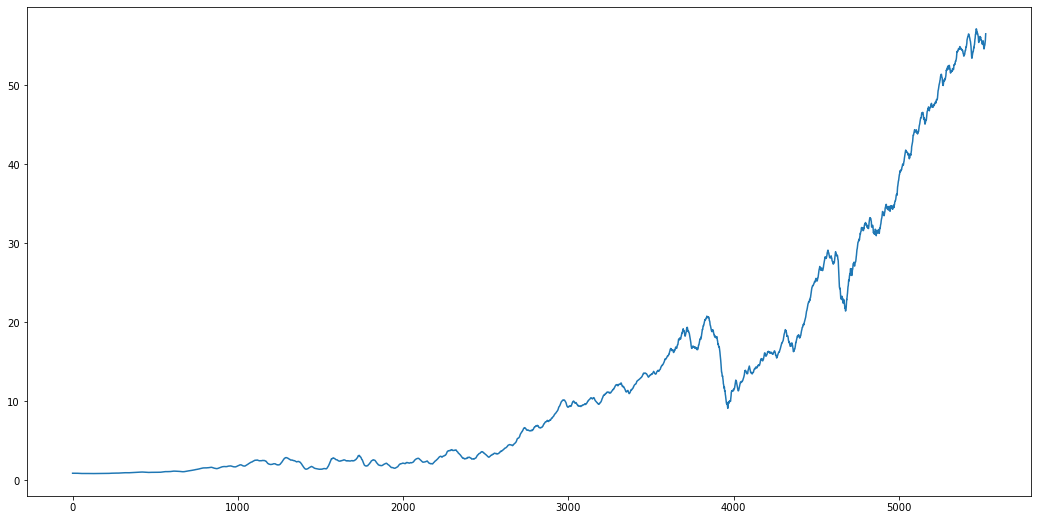

In [64]:
plt.figure(figsize=(18,9))
plt.plot(y_fit_30)
plt.show()


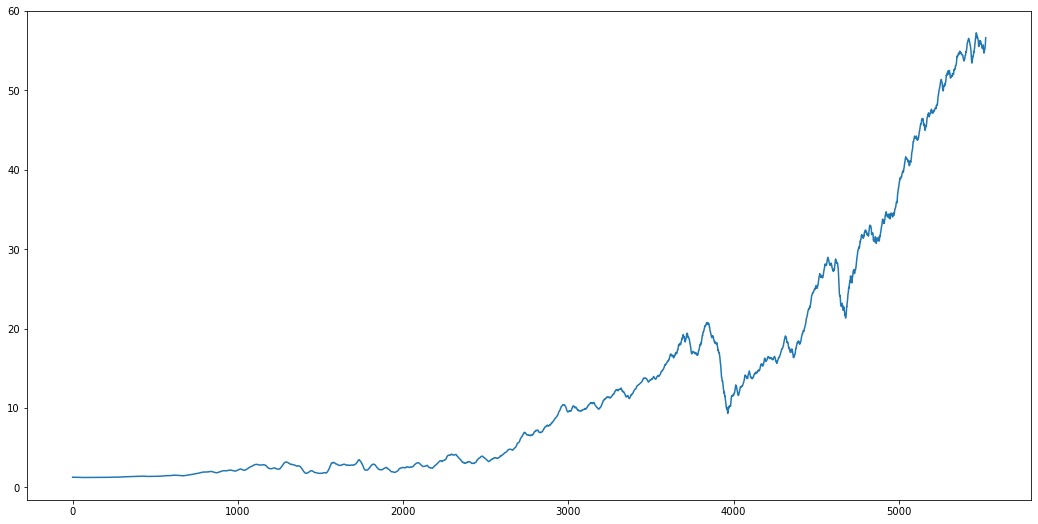

In [60]:
plt.figure(figsize=(18,9))
plt.plot(y_fit_30)
plt.show()


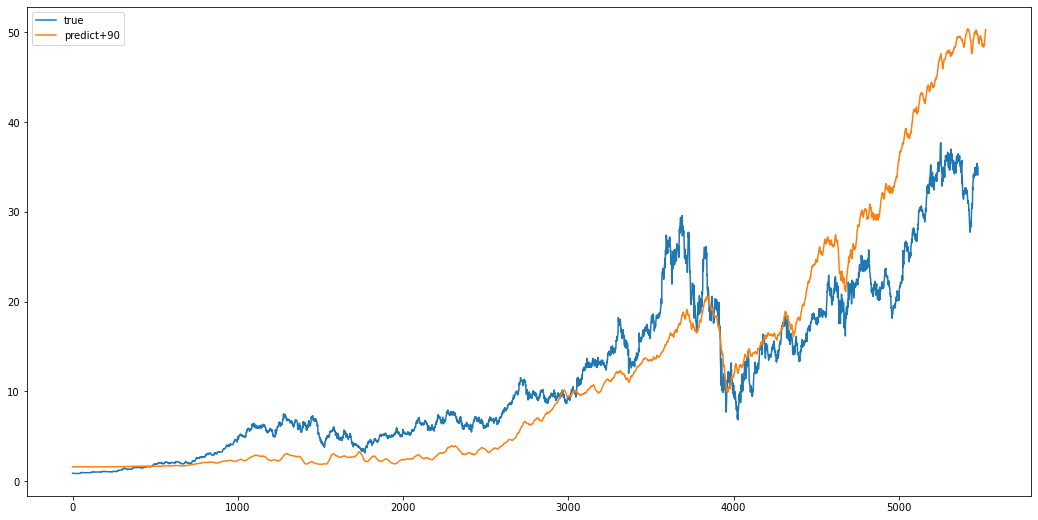

In [214]:
plt.figure(figsize=(18,9))
plt.plot(dta.B.iloc[30:30+y_fit.shape[0]].values)
plt.plot(y_fit_30)
plt.legend(['true', 'predict+90'])
plt.show()

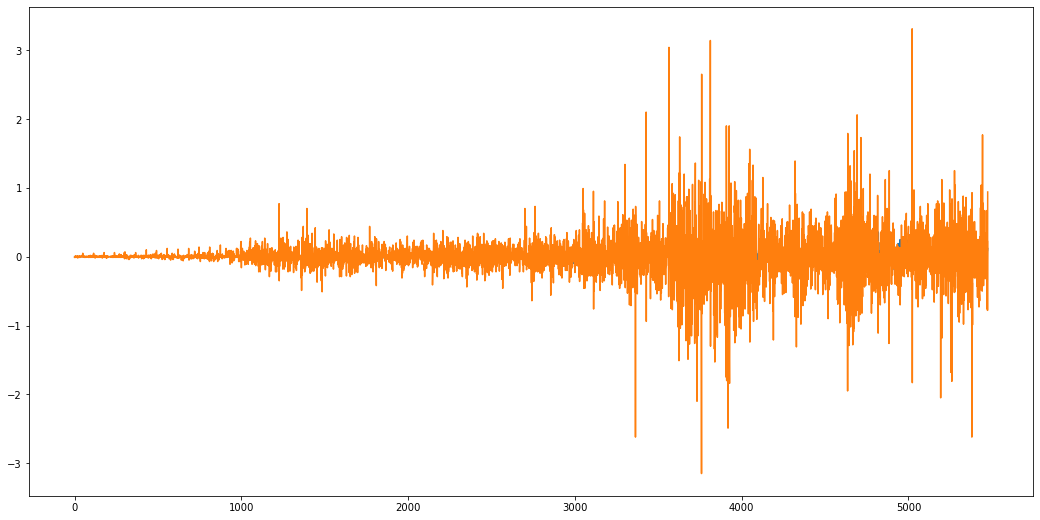

In [174]:
test = X[int(X.shape[0] * 0.8):,:]
scale = mm_scaler_x.transform(test)

scale = scale.reshape(scale.shape[0], 1, scale.shape[1])
y_fit = model.predict(scale)

y_fit = mm_scaler_y.inverse_transform(y_fit)

In [175]:
y_fit.shape

(1370, 1)

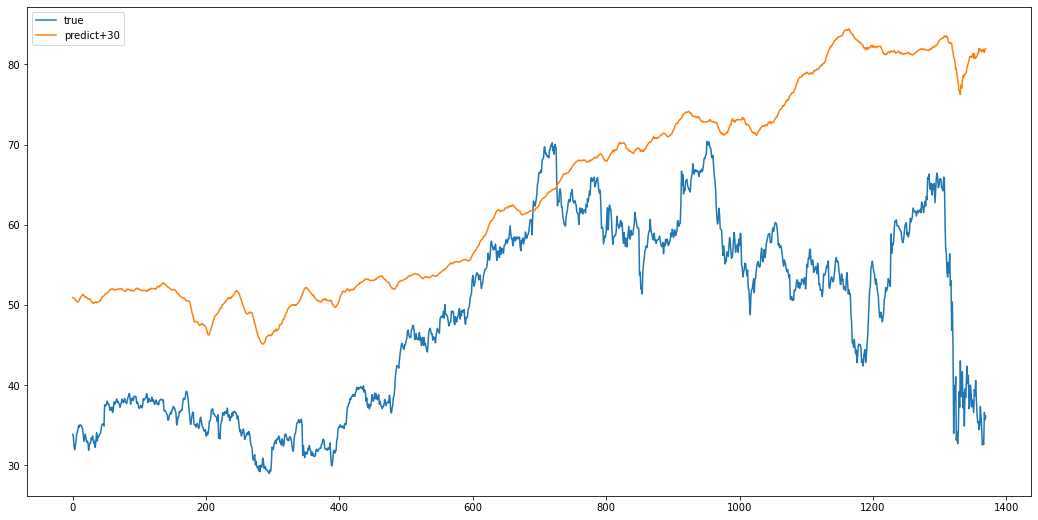

In [176]:
plt.figure(figsize=(18,9))
plt.plot(dta.B.iloc[int(X.shape[0] * 0.8)+30:int(X.shape[0] * 0.8)+30+y_fit.shape[0]].values)
plt.plot(y_fit)
plt.legend(['true', 'predict+30'])
plt.show()

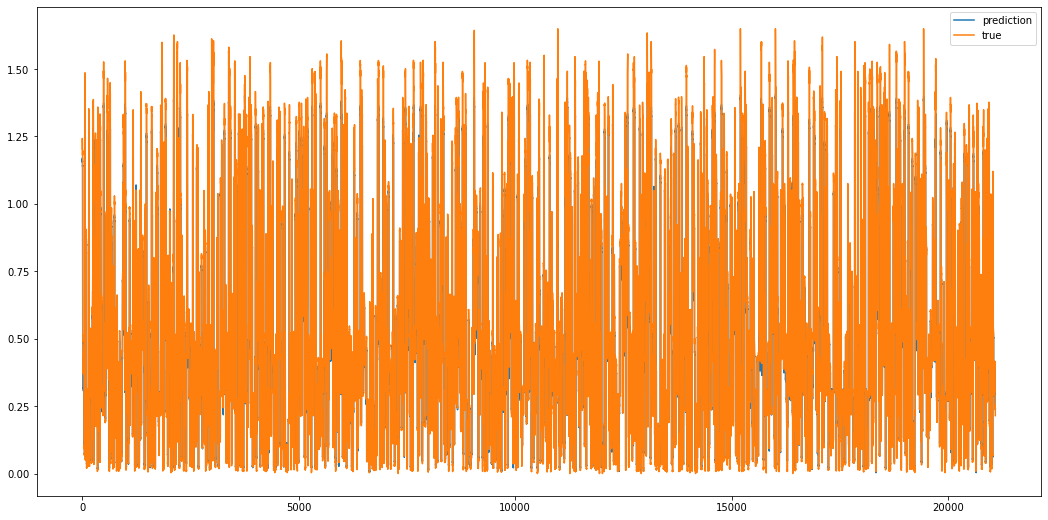

In [225]:
y_fit = model.predict(X_train)
y_fit = y_fit.flatten()

plt.figure(figsize=(18,9))
pd.Series(y_fit).plot()
pd.Series(Y_train.flatten()).plot()
plt.legend(['prediction', 'true'])

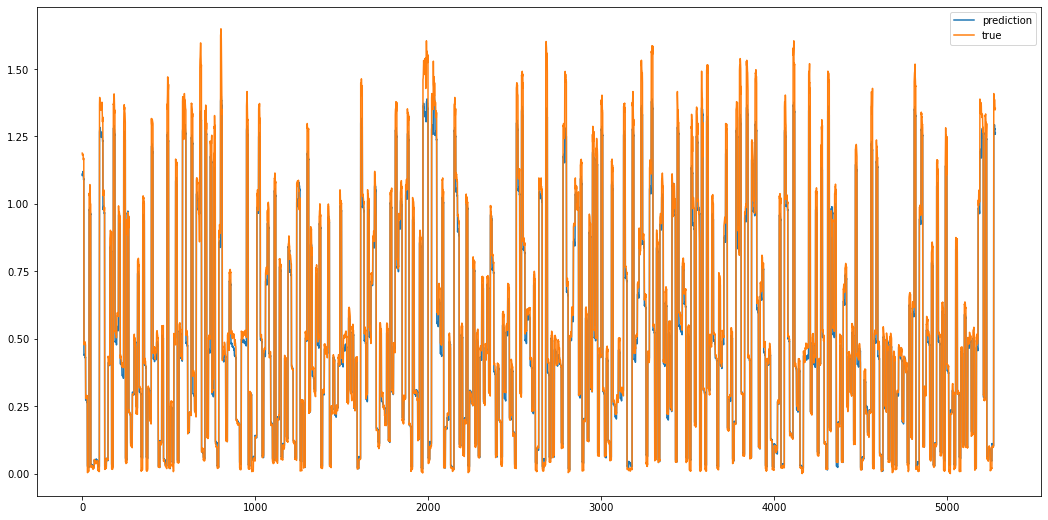

In [226]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

plt.figure(figsize=(18,9))
pd.Series(y_pred).plot()
pd.Series(Y_test.flatten()).plot()
plt.legend(['prediction', 'true'])

In [227]:
r2_in = r2_score(Y_train, y_fit)
r2_os = r2_score(Y_test, y_pred)

print("The in-sampel R-squared is {}, and the out-of-sampel R-square is {}.".format(r2_in, r2_os))


ValueError: Found input variables with inconsistent numbers of samples: [2109, 21090]

# Write this as a trading strategy

In [158]:
X = []
Y1 = []
Y2 = []

for i in range(len(smooth_dta)-120):
    x = smooth_sp[['PH', 'APH', 'OKE', 'UNP']].iloc[i:i+30].values.T.flatten()
    y1 = smooth_dta['AME'].iloc[i+90]
    y2 = smooth_dta['AME'].iloc[i+120] 
    X.append(x)
    Y1.append(y1)
    Y2.append(y2)

X = np.array(X)
Y1 = np.array(Y1).reshape(-1,1)
Y2 = np.array(Y2).reshape(-1,1)

print(X.shape, Y1.shape, Y2.shape)


(6798, 120) (6798, 1) (6798, 1)


In [159]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y1, test_size=0.4, random_state=42)

mm_scaler_x = StandardScaler()
mm_scaler_y_1 = StandardScaler()

mm_scaler_x = mm_scaler_x.fit(X_train)
mm_scaler_y_1 = mm_scaler_y_1.fit(Y_train)

X_train = mm_scaler_x.transform(X_train)
Y_train = mm_scaler_y_1.transform(Y_train)

X_test = mm_scaler_x.transform(X_test)
Y_test = mm_scaler_y_1.transform(Y_test)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

initializer = initializers.glorot_normal(seed=42)
model_1 = Sequential()
model_1.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
model_1.add(Dropout(0.4))
model_1.add(Dense(10, kernel_initializer=initializer))
model_1.add(Dropout(0.4))
model_1.add(Dense(1, kernel_initializer=initializer))
model_1.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)


model_1.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.4, random_state=42)

mm_scaler_x = StandardScaler()
mm_scaler_y_5 = StandardScaler()

mm_scaler_x = mm_scaler_x.fit(X_train)
mm_scaler_y_5 = mm_scaler_y_5.fit(Y_train)

X_train = mm_scaler_x.transform(X_train)
Y_train = mm_scaler_y_5.transform(Y_train)

X_test = mm_scaler_x.transform(X_test)
Y_test = mm_scaler_y_5.transform(Y_test)

X_train = X_train.reshape(X_train.shape[0], 1 , X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


model_5 = Sequential()
model_5.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
model_5.add(Dropout(0.4))
model_5.add(Dense(10, kernel_initializer=initializer))
model_5.add(Dropout(0.4))
model_5.add(Dense(1, kernel_initializer=initializer))
model_5.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)


model_5.fit(X_train, Y_train,
            batch_size=32,
            validation_data=(X_test, Y_test),
            epochs=50, 
            callbacks=[es])

Train on 4078 samples, validate on 2720 samples
Epoch 1/50
4078/4078 [==============================] - 2s 562us/step - loss: 0.3325 - coeff_deter: 0.7579 - val_loss: 0.1428 - val_coeff_deter: 0.9575
Epoch 2/50
4078/4078 [==============================] - 1s 207us/step - loss: 0.2725 - coeff_deter: 0.8312 - val_loss: 0.2242 - val_coeff_deter: 0.8982
Epoch 3/50
4078/4078 [==============================] - 1s 199us/step - loss: 0.2510 - coeff_deter: 0.8515 - val_loss: 0.1229 - val_coeff_deter: 0.9569
Epoch 4/50
4078/4078 [==============================] - 1s 217us/step - loss: 0.2492 - coeff_deter: 0.8594 - val_loss: 0.1103 - val_coeff_deter: 0.9763
Epoch 5/50
4078/4078 [==============================] - 1s 208us/step - loss: 0.2453 - coeff_deter: 0.8591 - val_loss: 0.1745 - val_coeff_deter: 0.9117
Epoch 6/50
4078/4078 [==============================] - 1s 205us/step - loss: 0.2429 - coeff_deter: 0.8584 - val_loss: 0.1003 - val_coeff_deter: 0.9765
Epoch 7/50
4078/4078 [==================

In [160]:
cutoff = int(X.shape[0] * 0.8)

train = X[:cutoff,:]
mm_scaler_x = mm_scaler_x.fit(train)
scale = mm_scaler_x.transform(train)
scale = scale.reshape(scale.shape[0], 1, scale.shape[1])

y_fit_30 = model_1.predict(scale)
y30_train = Y1[:cutoff]
mm_scaler_y_1 = mm_scaler_y_1.fit(y30_train)
y_fit_30 = mm_scaler_y_1.inverse_transform(y_fit_30)

y_fit_90 = model_5.predict(scale)
y90_train = Y2[:cutoff]
mm_scaler_y_5 = mm_scaler_y_5.fit(y90_train)
y_fit_90 = mm_scaler_y_5.inverse_transform(y_fit_90)

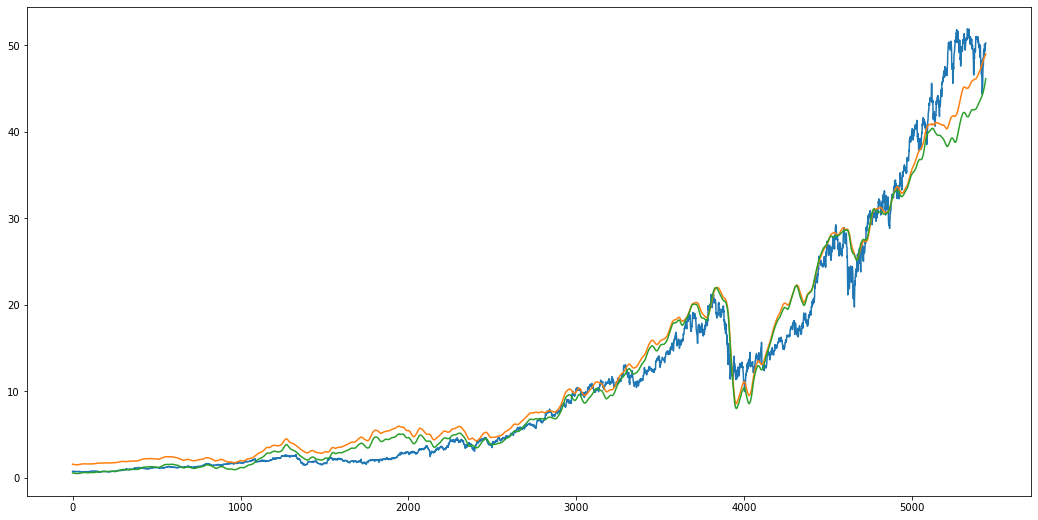

In [153]:
plt.figure(figsize=(18,9))
plt.plot(dta['AME'].iloc[50:50+y_fit_30.shape[0]].values)
plt.plot(y_fit_90)
plt.plot(y_fit_30)
plt.show()


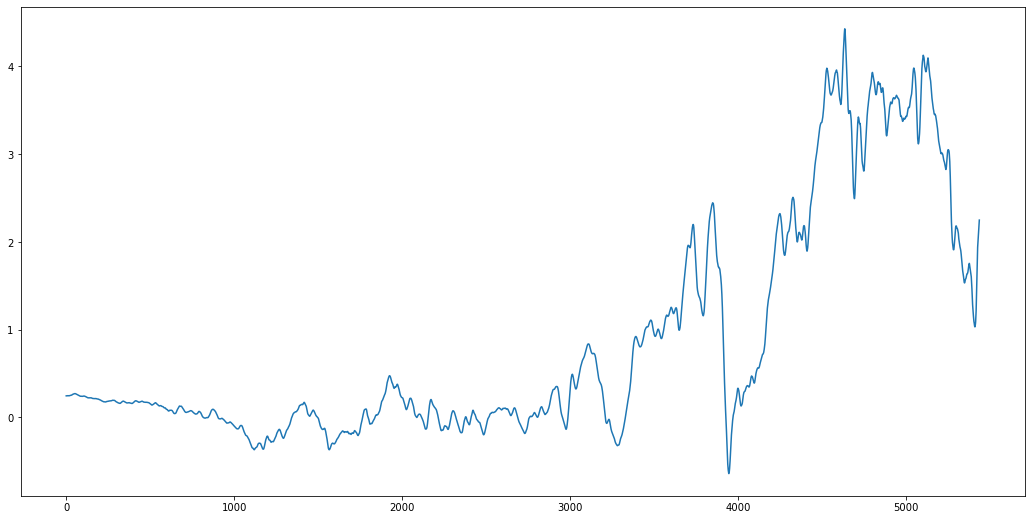

In [147]:
plt.figure(figsize=(18,9))
plt.plot(y_fit_90 - y_fit_30)
plt.show()


In [161]:
inventory = 0
asset = 0
record = [0]
forecast_diff = y_fit_90

for t in range(len(forecast_diff)):
    trend_good = forecast_diff[t] > dta['AME'].iloc[50+t]
    price = dta['AME'].iloc[50+t]
    if trend_good and inventory == 0:
        # buy
        asset -= price
        inventory += 1
    elif not trend_good and inventory == 1:
        # sell
        asset += price
        inventory -= 1
    else:
        asset = record[-1]
    record.append(asset)


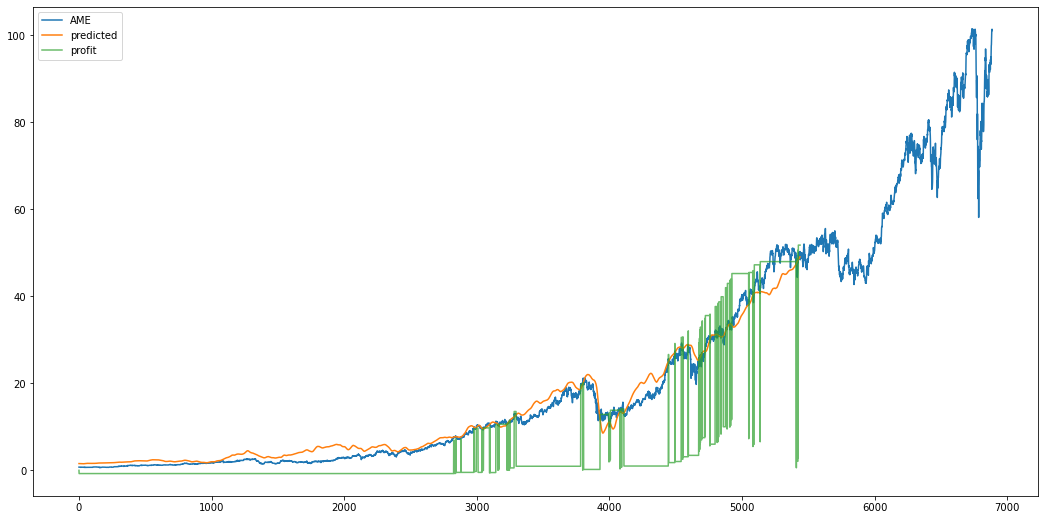

In [157]:
plt.figure(figsize=(18,9))
plt.plot(dta['AME'].iloc[50:].values)
plt.plot(y_fit_90)
plt.plot(record, alpha=0.7)
plt.legend(['AME', 'predicted', 'profit'])



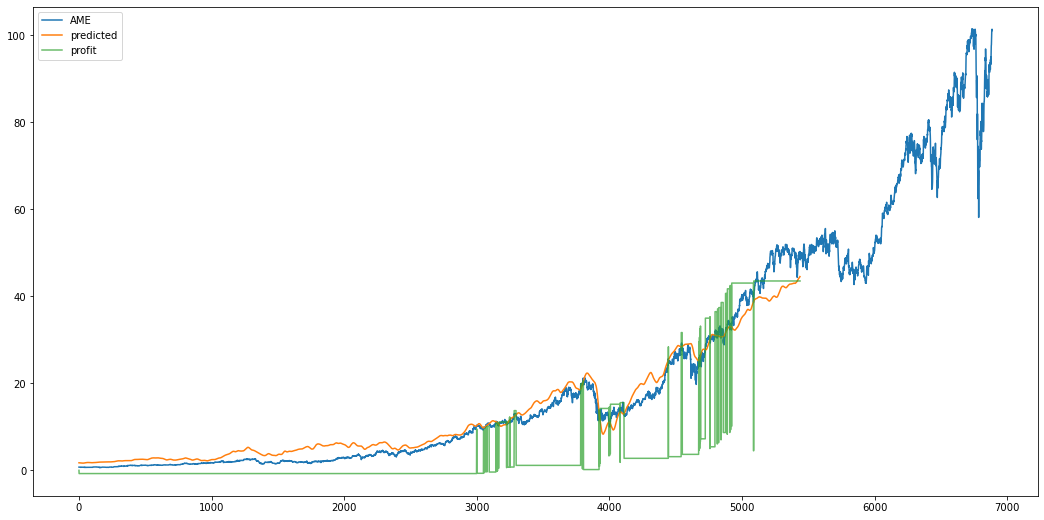

In [162]:
plt.figure(figsize=(18,9))
plt.plot(dta['AME'].iloc[50:].values)
plt.plot(y_fit_90)
plt.plot(record, alpha=0.7)
plt.legend(['AME', 'predicted', 'profit'])



In [119]:
inventory = 0
asset = 100
record = []
forecast_diff = smooth_dta['AME']

for t in range(2, len(forecast_diff)):
    trend_good = forecast_diff[t-2] < forecast_diff[t-1] and forecast_diff[t-1] < forecast_diff[t]
    price = dta['AME'].iloc[19+t]
    if trend_good and inventory == 0:
        # buy
        asset -= price
        inventory += 1
    elif not trend_good and inventory == 1:
        # sell
        asset += price
        inventory -= 1
    record.append(asset)


In [120]:
asset

38.94999999999989

In [197]:
t = X_train.shape[0]
record = [dta.iloc[t]]
while t < X.shape[0]:
    data = X[t,:]
    scale_data = mm_scaler_x.transform(data.reshape(1,-1))
    scale_data = scale_data.reshape(1,1, scale_data.shape[1])

    y1 = model_1.predict(scale_data)
    y5 = model_5.predict(scale_data)

    pr5 = mm_scaler_y_5.inverse_transform(y5)
    price = dta.iloc[t+30]
    if price < pr5:
        # buy
        record.append(price)
        t += 1
    else:
        # sell
        record.append(record[-1])
        t += 1

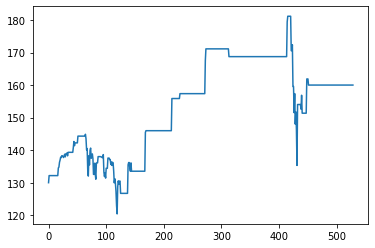

In [198]:
plt.plot(record)